In [364]:
import numpy as np
import cv2
import torch
import os
import matplotlib.pyplot as plt
import imutils
from os import listdir
from os.path import isfile, join

In [2]:
from keypoint_model import keypoint_model

In [3]:
def get_image(data_dir, file_name):
    path = os.path.join(data_dir, file_name)
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [4]:
def get_classifier(data_dir, file_name):
    path = os.path.join(data_dir, file_name)
    classifier = cv2.CascadeClassifier(path)
    return classifier

In [5]:
def convert_image_to_bw(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.equalizeHist(image)
    return image

In [6]:
def detect_faces(classifier, image):
#     bw_image = convert_image_to_bw(image)
    rects = classifier.detectMultiScale(image, 1.2, 2)
#     for x, y, w, h in rects:
#         cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    return rects

In [7]:
def detect_keypoints(model, image, faces, padding = 50):
    image_copy = image.copy()
    img_height, img_width = image.shape[0], image.shape[1]
    images, keypoints = [], []
    for coords in faces:
        img = image[max(0, coords[1]-padding): min(coords[1]+coords[-1]+padding, img_height), 
                    max(0, coords[0]-padding): min(coords[0]+coords[2]+padding, img_width)]
        img = (img/255.0).astype(np.float32)
        img = cv2.resize(img, (224, 224))
        images.append(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        if len(img.shape) == 2:
            img = np.expand_dims(img, axis=0)
        else:
            img = np.rollaxis(img, 2, 0)
        img = np.expand_dims(img, axis=0)
        img = torch.from_numpy(img).type(torch.FloatTensor)
        results = model.forward(img)
        results = results.view(results.size()[0], 68, -1).cpu()
        pred = results[0].cpu().data
        pred = pred.numpy()
        pred = pred * 50 + 100
        keypoints.append(pred)
    return images, keypoints

In [8]:
model = keypoint_model()
model.load_state_dict(torch.load("./models/keypoint_detection_model.pth", map_location='cpu'))
model.eval()
classifier = get_classifier(data_dir="./models", file_name="face_detection_model.xml")

In [379]:
image = get_image(data_dir="./images", file_name="girl.jpg")
faces = detect_faces(classifier=classifier, image=image)

In [338]:
images, keypoints = detect_keypoints(faces=faces, image=image, model=model, padding=50)

In [339]:
def visualize_output(faces, test_outputs):  
    for i, face in enumerate(faces):
        plt.figure(figsize=(5, 5))
        plt.imshow(face)
        plt.scatter(test_outputs[i][:, 0], test_outputs[i][:, 1], s=20, marker='.', c='m')
        plt.axis('off')
    plt.show()

In [340]:
# def apply_sunglasses(image, sunglasses, key_pts):
#     # Display sunglasses on top of the image in the appropriate place
#     image_copy = np.copy(image)

#     # top-left location for sunglasses to go
#     # 17 = edge of left eyebrow
#     x = int(key_pts[17, 0])
#     y = int(key_pts[17, 1])

#     # height and width of sunglasses
#     # h = length of nose
#     h = int(abs(key_pts[27,1] - key_pts[34,1]))
#     # w = left to right eyebrow edges`
#     w = int(abs(key_pts[17,0] - key_pts[26,0]))

#     # read in sunglasses
#     sunglasses = cv2.imread('filters/sunglasses.png', cv2.IMREAD_UNCHANGED)
#     # resize sunglasses
#     new_sunglasses =  cv2.resize(sunglasses, (w, h), interpolation = cv2.INTER_CUBIC)

#     # get region of interest on the face to change
#     roi_color = image_copy[y:y+h,x:x+w]

#     # find all non-transparent pts
#     ind = np.argwhere(new_sunglasses[:,:,3] > 0)

#     # for each non-transparent point, replace the original image pixel with that of the new_sunglasses
#     for i in range(3):
#         roi_color[ind[:,0],ind[:,1],i] = new_sunglasses[ind[:,0],ind[:,1],i]    
#     # set the area of the image to the changed region with sunglasses
#     image_copy[y:y+h,x:x+w] = roi_color
#     plt.imshow(image_copy)
#     return image_copy
# #     plt.imshow(roi_color)
#     # display the result!
#     # plt.imshow(image_copy)

In [341]:
def apply_dog_filter(face, filt):
    filt_h, filt_w, _ = filt.shape
    face_h, face_w, _ = face.shape
    factor = min(face_h/filt_h, face_w/filt_w)
    new_filt_h, new_filt_w = int(filt_h*factor), int(filt_w*factor)
    new_filt_shape = (new_filt_w, new_filt_h)
    resized_filter = cv2.resize(filt, new_filt_shape)
    masked_face = face.copy()
    non_white_pixels = (resized_filter < 250).all(axis = 2)
    offset_h, offset_w = int((face_h-new_filt_h)/2), int((face_w-new_filt_w)/2)
    masked_face[offset_h:offset_h+new_filt_h, offset_w:offset_w+new_filt_w][non_white_pixels] = resized_filter[non_white_pixels]
    return masked_face

In [342]:
def dog_face_filter(image, classifier, dog_filter):
    image_h, image_w = image.shape[0], image.shape[1]
    rectangles = detect_faces(classifier=classifier, image=image)
    for x, y, w, h in rectangles:
        y0, y1 = int(y - 0.25*h), int(y + 0.75*h)
        x0, x1 = x, x + w
        if x0 < 0 or y0 < 0 or x1 > image_w or y1 > image_h:
            continue
        image[y0: y1, x0: x1] = apply_dog_filter(image[y0: y1, x0: x1], dog_filter)
    return image

In [343]:
def overlay_filter_on_image(img, filt, off_x, off_y):
    (h,w) = (filt.shape[0], filt.shape[1])
    (imgH,imgW) = (img.shape[0], img.shape[1])
    if off_y+h >= imgH: 
        filt = filt[0:imgH-off_y,:,:]
    if off_x+w >= imgW:
        filt = filt[:,0:imgW-off_x,:]
    if off_x < 0:
        filt = filt[:,abs(off_x)::,:]
        w = filt.shape[1]
        off_x = 0
    for c in range(3):
        img[off_y:int(off_y+h), off_x:int(off_x+w), c] =  \
        filt[:,:,c] * (filt[:,:,3]/255.0) +  img[off_y:off_y+h, off_x:off_x+w, c] * (1.0 - filt[:,:,3]/255.0)
    return img

In [344]:
def get_part_filter(img, model,scale = 1.1, neighbors = 5, width = 30):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    features = model.detectMultiScale(
        gray,
        scaleFactor=scale,
        minNeighbors=neighbors,
        minSize=(width, width),
        flags=cv2.CASCADE_SCALE_IMAGE
    )
    return features

In [352]:
def apply_sunglasses_filter(img, filt, part_filter, off_x, off_y, off_y_image, actual_width, x, y, w, h):
    (filt_h,filt_w) = (filt.shape[0], filt.shape[1])
    xpos = x + off_x
    ypos = y + off_y
    factor = 1.0 * actual_width/filt_w
    sub_img = img[y+off_y_image:y+h, x:x+w,:]
    feature = get_part_filter(sub_img, part_filter, 1.3 , 10, 10)
    if len(feature) != 0:
        xpos, ypos = x, y + feature[0,1]
    filt = cv2.resize(filt, (0,0), fx=factor, fy=factor)
    img = overlay_filter_on_image(img, filt, xpos, int(ypos))
    return img

In [353]:
def apply_mustache_filter(img, filt, part_filter, off_x, off_y, off_y_image, actual_width, x, y, w, h):
    (filt_h,filt_w) = (filt.shape[0], filt.shape[1])
    xpos = x + off_x
    ypos = y + off_y
    factor = 1.0 * actual_width/filt_w
    sub_img = img[y+off_y_image:y+h, x:x+w,:]
    feature = get_part_filter(sub_img, part_filter, 1.3 , 10, 10)
    if len(feature) != 0:
        xpos, ypos = x, y + feature[0,1]
        size_mustache = 1.2
        factor = 1.0*(feature[0,2]*size_mustache)/filt_w
        xpos =  x + feature[0,0] - int(feature[0,2]*(size_mustache-1)/2)
        ypos = y + off_y_image + feature[0,1] - int(filt_h*factor)
    filt = cv2.resize(filt, (0,0), fx=factor, fy=factor)
    img = overlay_filter_on_image(img, filt, xpos, int(ypos))
    return img

In [354]:
x, y, w, h = faces[0]
haar_eyes = cv2.CascadeClassifier('./models/haarcascade_eye.xml')
haar_mouth = cv2.CascadeClassifier('./models/Mouth.xml')

In [357]:
sunglasses = cv2.imread("./filters/sunglasses.png", -1)
f = apply_sunglasses_filter(image.copy(), sunglasses, haar_eyes, 0, h/3, 0, w, x, y, w, h)

In [358]:
mustache = cv2.imread("./filters/mustache.png", -1)
g = apply_mustache_filter(image.copy(), mustache, haar_mouth, int(w/4), int(4*h/5), int(h/2), int(w/2), x, y, w, h)

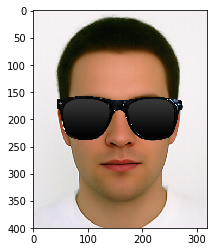

In [381]:
plt.imshow(f)